# Classification
- Frozen encoder layers with fully convolutional layer
- Re-training the model with the learned weights from the autoencoder
- Randomly initialized model


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
# Test connection and path to images
!ls "/gdrive/My Drive/computer-vision-project/dataset_resampled"

images	labels	segmentation


In [3]:
!python "/gdrive/My Drive/computer-vision-project/utils.py"

Using TensorFlow backend.


In [4]:
!pip install livelossplot

In [5]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
import numpy as np
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
exec(open('/gdrive/My Drive/computer-vision-project/utils.py').read())

In [0]:
PATH_TO_DATASET = "/gdrive/My Drive/computer-vision-project/dataset_resampled/"
PATH_TO_MODELS = "/gdrive/My Drive/computer-vision-project/models/"

In [0]:
x_train = read_train_images()
x_val = read_validation_images()
x_test = read_test_images()

In [0]:
y_train = read_train_labels()
y_val = read_validation_labels()
y_test = read_test_labels()

In [10]:
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val.shape))
print("Test set (images) shape: {shape}".format(shape=x_test.shape))

Training set (images) shape: (467, 128, 128, 3)
Validation set (images) shape: (386, 128, 128, 3)
Test set (images) shape: (97, 128, 128, 3)


In [11]:
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))
print("Validation set (labels) shape: {shape}".format(shape=y_val.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training set (labels) shape: (467, 2)
Validation set (labels) shape: (386, 2)
Test set (labels) shape: (97, 2)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0 1]')

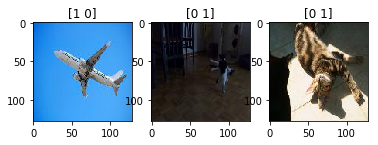

In [12]:
# Display the first image from training data
i=0
plt.subplot(131)
plt.imshow(x_train[i], cmap='gray')
plt.title(y_train[i])

# Display the first image from validation data
plt.subplot(132)
plt.imshow(x_val[i], cmap='gray')
plt.title(y_val[i])

# Display the first image from test data
plt.subplot(133)
plt.imshow(x_test[i], cmap='gray')
plt.title(y_test[i])

Definition of hyperparameters.

In [13]:
batch_size = 32
epochs = 50
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

W0616 15:44:19.612264 139713327830912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 15:44:19.641974 139713327830912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
OPTIMIZER=keras.optimizers.RMSprop()
LOSS=keras.losses.binary_crossentropy

In [0]:
def fully_connected(encoder):
    drop1 = Dropout(rate=0.2)(encoder)
    flat = Flatten()(drop1)
    out = Dense(num_classes, activation='sigmoid')(flat)
    return out

Read the previously trained autoencoder with 16 x 16 x 32 coding variables.

In [73]:
autoencoder = read_model('autoencoder_16_16_32')

Loaded model from disk


In [17]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
code_layer = autoencoder.get_layer('conv2d_4').output
encoder = Model(inputs=autoencoder.input, outputs=code_layer)

In [75]:
num_encoder_layers = len(encoder.layers)
print('Number of layers in the encoder: ' + str(num_encoder_layers))

Number of layers in the encoder: 8


In [0]:
# Make the encoder part - trainable false
# The encoder part is already trained, so no need to train it
# Only train the Fully Connected part
for layer in encoder.layers:
    layer.trainable = False

In [0]:
full_model = Model(encoder.input, fully_connected(code_layer))

In [80]:
autoencoder.get_weights()[0][1]

array([[[ 0.01323952, -0.00924409,  0.00310192, ..., -0.04057597,
         -0.06072473, -0.05801255],
        [ 0.00963   ,  0.00772085, -0.01098589, ..., -0.0638267 ,
         -0.01184958, -0.02496099],
        [ 0.01838502,  0.03851731,  0.03420471, ..., -0.02149975,
          0.01946681,  0.00314596]],

       [[-0.01698609, -0.0348401 , -0.03695113, ...,  0.03578053,
         -0.05225025, -0.00930003],
        [ 0.0294446 , -0.05519595,  0.01963622, ..., -0.06116683,
         -0.00631217,  0.02214977],
        [ 0.037844  , -0.04423049,  0.02608612, ...,  0.00403284,
          0.02888304, -0.05575034]],

       [[ 0.03042884,  0.03041432,  0.01311218, ..., -0.03562213,
         -0.01174426, -0.0305305 ],
        [-0.01339445, -0.02303229, -0.05407059, ..., -0.00261315,
          0.03732682,  0.02369348],
        [ 0.02181922,  0.03372758,  0.02793828, ..., -0.05246742,
         -0.04201533,  0.01234026]]], dtype=float32)

In [79]:
full_model.get_weights()[0][1]

array([[[ 0.01323952, -0.00924409,  0.00310192, ..., -0.04057597,
         -0.06072473, -0.05801255],
        [ 0.00963   ,  0.00772085, -0.01098589, ..., -0.0638267 ,
         -0.01184958, -0.02496099],
        [ 0.01838502,  0.03851731,  0.03420471, ..., -0.02149975,
          0.01946681,  0.00314596]],

       [[-0.01698609, -0.0348401 , -0.03695113, ...,  0.03578053,
         -0.05225025, -0.00930003],
        [ 0.0294446 , -0.05519595,  0.01963622, ..., -0.06116683,
         -0.00631217,  0.02214977],
        [ 0.037844  , -0.04423049,  0.02608612, ...,  0.00403284,
          0.02888304, -0.05575034]],

       [[ 0.03042884,  0.03041432,  0.01311218, ..., -0.03562213,
         -0.01174426, -0.0305305 ],
        [-0.01339445, -0.02303229, -0.05407059, ..., -0.00261315,
          0.03732682,  0.02369348],
        [ 0.02181922,  0.03372758,  0.02793828, ..., -0.05246742,
         -0.04201533,  0.01234026]]], dtype=float32)

In [78]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
# Compile the model
full_model.compile(loss=LOSS, 
                   optimizer=OPTIMIZER,
                   metrics=['accuracy'])

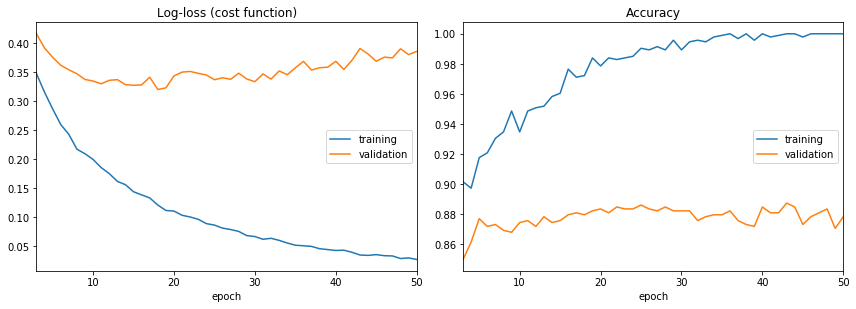

Log-loss (cost function):
training   (min:    0.027, max:    0.522, cur:    0.027)
validation (min:    0.320, max:    0.470, cur:    0.385)

Accuracy:
training   (min:    0.777, max:    1.000, cur:    1.000)
validation (min:    0.846, max:    0.887, cur:    0.878)


In [82]:
classify_train = full_model.fit(x_train, 
                                y_train, 
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_val, y_val),
                                callbacks=[PlotLossesKeras()])

Definition of evaluation methods.

In [0]:
def get_train_val_performance(autoencoder_train):
  print('Loss (training set): ' + str(np.mean(autoencoder_train.history['loss'])))
  print('Validtion Loss (val set): ' + str(np.mean(autoencoder_train.history['val_loss'])))

In [0]:
# Model evaluation on test set
def evaluate_test_set(full_model):
    test_eval = full_model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

In [0]:
# Predict labels
def predict_labels(full_model): 
    predicted_classes = full_model.predict(x_test)
    predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
    return predicted_classes

In [0]:
# Plot few predicted images and their class
def plot_predicted_images(predicted_images):
    for i, predicted_image in enumerate(predicted_images[:6]):
        plt.subplot(2, 3, i+1)
        plt.imshow(x_test[predicted_image], cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[predicted_image], y_test_flat[predicted_image]))
        plt.tight_layout()

In [0]:
# Confusion matrix
def get_confusion_matrix(predicted_classes, y_test_flat):
    tn, fp, fn, tp = confusion_matrix(predicted_classes, y_test_flat).ravel()
    print("(tn, fp, fn, tp) = ({}, {}, {}, {})".format(tn, fp, fn, tp))

#### Check the performance of the classifier with frozen encoder layers.

Loss value on training and validation sets (while training)

In [85]:
save_model(full_model, 'full_model')

Saved model to disk


In [83]:
get_train_val_performance(classify_train)

Loss (training set): 0.12272439616586717
Validtion Loss (val set): 0.3577020771847797


Model Evaluation on the Test Set

In [84]:
evaluate_test_set(full_model)

Test loss: 0.41702105318551363
Test accuracy: 0.865979381443299


Found 84 correct labels


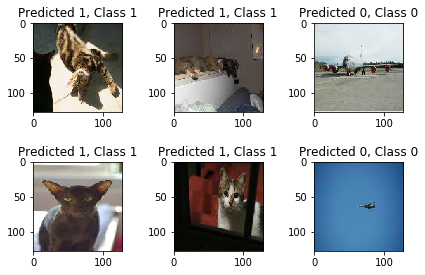

In [86]:
# For the first model (frozen autoencoder + connected NN)
y_test_flat = np.argmax(y_test,axis=1)
predicted_classes = predict_labels(full_model)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 13 incorrect labels


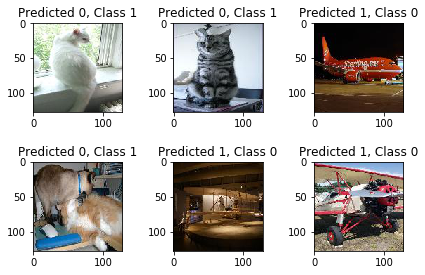

In [87]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)

In [88]:
get_confusion_matrix(predicted_classes, y_test_flat)

(tn, fp, fn, tp) = (38, 7, 6, 46)


#### Re-train the model once again, by making the encoder layers trainable, instead of freezing them.

In [89]:
full_model_tr = read_model('full_model')

Loaded model from disk


In [0]:
for layer in full_model_tr.layers:
    layer.trainable = True
    
full_model_tr.compile(loss=LOSS, 
                     optimizer=OPTIMIZER,
                     metrics=['accuracy'])

In [91]:
full_model_tr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

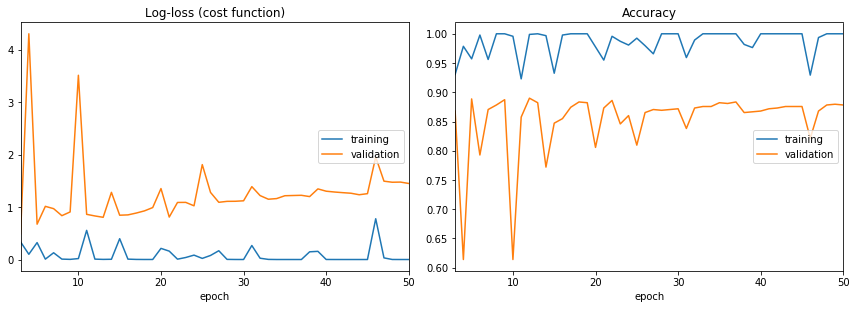

Log-loss (cost function):
training   (min:    0.000, max:    0.777, cur:    0.000)
validation (min:    0.488, max:    4.301, cur:    1.449)

Accuracy:
training   (min:    0.882, max:    1.000, cur:    1.000)
validation (min:    0.614, max:    0.890, cur:    0.878)


In [92]:
classify_train_retr = full_model_tr.fit(x_train, 
                                        y_train, 
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        verbose=1,
                                        validation_data=(x_val, y_val),
                                        callbacks=[PlotLossesKeras()])

Next, the performance of the re-trained model is checked.

Loss value on training and validation sets (while training)

In [93]:
get_train_val_performance(classify_train_retr)

Loss (training set): 0.09742293143887429
Validtion Loss (val set): 1.2364873835007264


In [94]:
evaluate_test_set(full_model_tr)

Test loss: 1.0344024354888368
Test accuracy: 0.9020618556701031


Found 88 correct labels


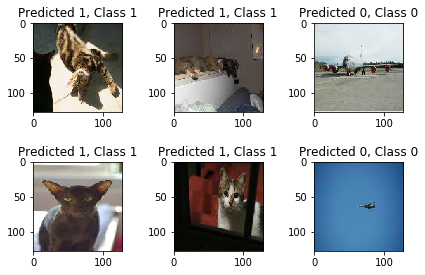

In [95]:
predicted_classes = predict_labels(full_model_tr)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 9 incorrect labels


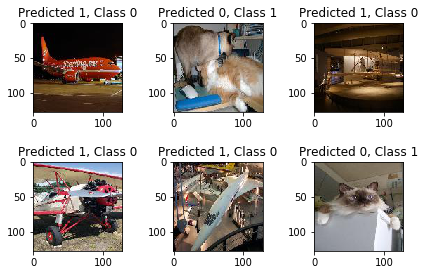

In [96]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)

In [97]:
get_confusion_matrix(predicted_classes, y_test_flat)

(tn, fp, fn, tp) = (38, 3, 6, 50)


Next, the model is trained with randomly initialized weights.


In [107]:
autoencoder = read_model('autoencoder_16_16_32')
code_layer = autoencoder.get_layer('conv2d_4').output
encoder = Model(inputs=autoencoder.input, outputs=code_layer)
epochs = 8 # taken from the random search

Loaded model from disk


In [0]:
# Full_model_2 - model trained with randomly initialized weights
# Random weight init
for layer in encoder.layers:
  layer.trainable=True
  if hasattr(layer,'kernel_initializer'):
    layer.kernel_initializer = 'random_uniform'
    layer.bias_initializer = 'zeros'
            
full_model_2 = Model(encoder.input, fully_connected(encoder.output))

In [109]:
full_model_2.compile(loss=LOSS, 
                     optimizer=OPTIMIZER,
                     metrics=['accuracy'])
full_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
__________

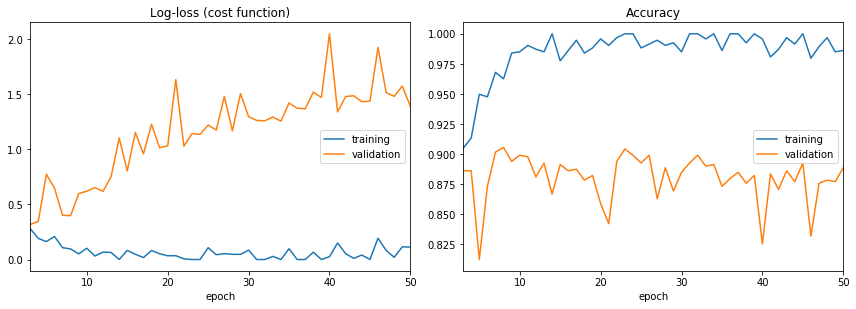

Log-loss (cost function):
training   (min:    0.000, max:    0.515, cur:    0.113)
validation (min:    0.318, max:    2.050, cur:    1.390)

Accuracy:
training   (min:    0.802, max:    1.000, cur:    0.986)
validation (min:    0.767, max:    0.905, cur:    0.889)


In [110]:
classify_train_2 = full_model_2.fit(x_train, 
                                    y_train, 
                                    batch_size=epochs,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_val, y_val),
                                    callbacks=[PlotLossesKeras()])

Loss value on training and validation sets (while training)

In [111]:
get_train_val_performance(classify_train_2)

Loss (training set): 0.07996449858173418
Validtion Loss (val set): 1.128104019515433


In [112]:
evaluate_test_set(full_model_2)

Test loss: 1.7752469064272933
Test accuracy: 0.8556701030927835


Found 83 correct labels


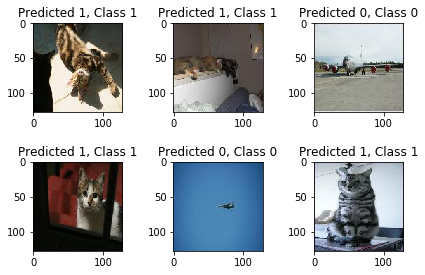

In [113]:
predicted_classes = predict_labels(full_model_2)
correct = np.where(predicted_classes==y_test_flat)[0]
incorrect = np.where(predicted_classes!=y_test_flat)[0]

print("Found %d correct labels"% len(correct))
plot_predicted_images(correct)

Found 14 incorrect labels


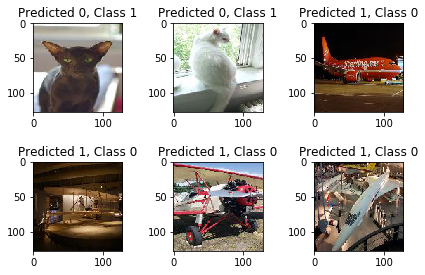

In [114]:
print("Found %d incorrect labels"% len(incorrect))
plot_predicted_images(incorrect)

In [115]:
get_confusion_matrix(predicted_classes, y_test_flat)

(tn, fp, fn, tp) = (37, 7, 7, 46)
